# Coregistration of two satellite image data sources

In this tutorial, you'll learn how to use [stackstac](https://stackstac.readthedocs.io/en/latest/) on Planetary Computer to align two spatially overlapping raster images from Sentinel-2 and Landsat-8 into a single dataset. You will then calculate the [Normalized difference vegetation index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) of the resulting dataset and compare it to the NDVI based on the original data.

This tutorial covers the following steps:
- Loading [STAC item](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md) data with [pystac](https://pystac.readthedocs.io/en/latest/) and matching local coordinates of Sentinel and Landsat data with [pystac_client](https://pystac-client.readthedocs.io/en/latest/)
- Reprojecting and resampling Sentinel and Landsat data to use a common resolution and coordinate system
- Croping to the region of interest and aligning Sentinel and Landsat data into a single dataset
- Calculating and comparing NDVIs with [xarray-spatial](https://xarray-spatial.org/index.html)

This tutorial requires data that includes STAC Items as defined by the [SpatioTemporal Asset Catalog (STAC)](http://stacspec.org/) specification. All remote-sensing datasets in the [Planetary Computer's data catalog](https://planetarycomputer.microsoft.com/catalog) include the necessary STAC Item data.

In [1]:
import planetary_computer as pc

import numpy as np
import pandas as pd
import xarray as xr

import stackstac
import pystac_client
import pystac

import xrspatial.multispectral as ms

## Preparation: create a local Dask cluster

In this tutorial, you'll be using a small dataset. Create a local Dask cluster to hold your data.

In [2]:
from dask.distributed import Client

client = Client()
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


To follow the progress of your computations, you can [access the Dask Dashboard](https://planetarycomputer.microsoft.com/docs/quickstarts/scale-with-dask/#Open-the-dashboard) at the URL from the previous cell's output.

## Load matching Sentinel and Landsat datasets

The area of interest covers a small section of the Mississippi River, USA, near the Yazoo National Wildlife Refuge. Because the two datasets have different tiling boundaries, we first use [pystac](https://pystac.readthedocs.io/en/latest/) to select a scene from Sentinel and then create a median mosaic from some Landsat scenes that overlap with the selected Sentinel scene. 

In [3]:
sentinel_item_id = "S2B_MSIL2A_20200907T163839_N0212_R126_T15SXS_20200918T192927.SAFE"
sentinel_item = pystac.read_file(
    "https://planetarycomputer.microsoft.com/api/stac/v1/collections/"
    f"sentinel-2-l2a/items/{sentinel_item_id}"
)
sentinel_item = pc.sign_assets(sentinel_item).to_dict()

sentinel_item["id"], sentinel_item["geometry"], sentinel_item["properties"]["proj:epsg"]

('S2B_MSIL2A_20200907T163839_N0212_R126_T15SXS_20200918T192927.SAFE',
 {'coordinates': [[[-91.924225, 33.43490919],
    [-90.74362, 33.41904671],
    [-90.768616, 32.42935916],
    [-91.93616, 32.44463539],
    [-91.924225, 33.43490919]]],
  'type': 'Polygon'},
 32615)

Set the bounds of the selected Sentinel image as the area of interest. Then, use [pystac_client](https://pystac-client.readthedocs.io/en/latest/) to identify all matching Landsat images with a cloud coverage of less than 10 percent in September 2020.

In [4]:
area_of_interest = sentinel_item["geometry"]

time_of_interest = "2020-09-01/2020-09-30"

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)
search = catalog.search(
    collections=["landsat-8-c2-l2"],
    intersects=area_of_interest,
    datetime=time_of_interest,
)

landsat_signed_items = [
    pc.sign_assets(item)
    for item in search.items()
    if item.properties["eo:cloud_cover"] < 10
]
landsat_items = pystac_client.ItemCollection(landsat_signed_items)

landsat_signed_items

[<Item id=LC08_L2SP_024038_20200930_20201007_02_T1>,
 <Item id=LC08_L2SP_024037_20200930_20201007_02_T1>,
 <Item id=LC08_L2SP_023037_20200907_20200919_02_T1>,
 <Item id=LC08_L2SP_023038_20200907_20200918_02_T1>]

## Match Sentinel and Landsat data properties

Begin by reading the Sentinel STAC data in its original [Coordinate Reference System (CRS)](https://gdal.org/tutorials/osr_api_tut.html) `epsg=32615`, using a resolution of 100m.

In [5]:
sentinel_data = (
    stackstac.stack(
        sentinel_item,
        resolution=100,
        assets=["B02", "B03", "B04", "B08"],  # blue, green, red, nir
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
)[0].persist()

sentinel_data.spec, sentinel_data.resolution, sentinel_data.shape

(RasterSpec(epsg=32615, bounds=(600000, 3590200, 709800, 3700100), resolutions_xy=(100, 100)),
 100,
 (4, 1099, 1098))

Before coregistering data, you need to make sure that both data sets use the same resolution and the same CRS. Use `stackstac.stack` to set the `epsg` and `resolution` properties of your Landast data to match the CRS and resolution of your Sentinel data.

Translating data from one CRS to another is called reprojection. See [this notebook]() to find out more about how to perform reprojection on Planetary Computer.

In [6]:
landsat_data = (
    (
        stackstac.stack(
            landsat_items,
            resolution=sentinel_data.resolution,  # resample to resolution of Sentinel data (10m)
            epsg=sentinel_data.spec.epsg,  # reporoject to CRS of Sentinel data (epsg=32615)
            bounds=sentinel_data.spec.bounds,  # set bounds to match Sentinel data
            assets=["SR_B2", "SR_B3", "SR_B4", "SR_B5"],  # blue, green, red, nir
        )
        .where(lambda x: x > 0, other=np.nan)  # landsat-8 sometimes uses 0 as nodata
        .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
    )
    .median(dim="time", keep_attrs=True)
    .persist()
)

landsat_data.spec, landsat_data.shape

(RasterSpec(epsg=32615, bounds=(600000, 3590200, 709800, 3700100), resolutions_xy=(100, 100)),
 (4, 1099, 1098))

Both the Sentinel and the Landsat data should now have the same raster spec information. To make sure, check whether their x and y coordinates match.

In [7]:
(landsat_data.x.data == sentinel_data.x.data).all()

True

In [8]:
(landsat_data.y.data == sentinel_data.y.data).all()

True

To display a preview of the two data sets, use the [xrspatial.multispectral.true_color](https://xarray-spatial.org/reference/_autosummary/xrspatial.multispectral.true_color.html) function with `sentinel_data` and `landsat_data`. 

Provide the following parameters:
* the three bands of red, green, and blue from the respective satellite's data
* the two optional numeric parameters `c` and `th` to adjust contrast and brightness, respectively
* the optional string value `name` to name each image

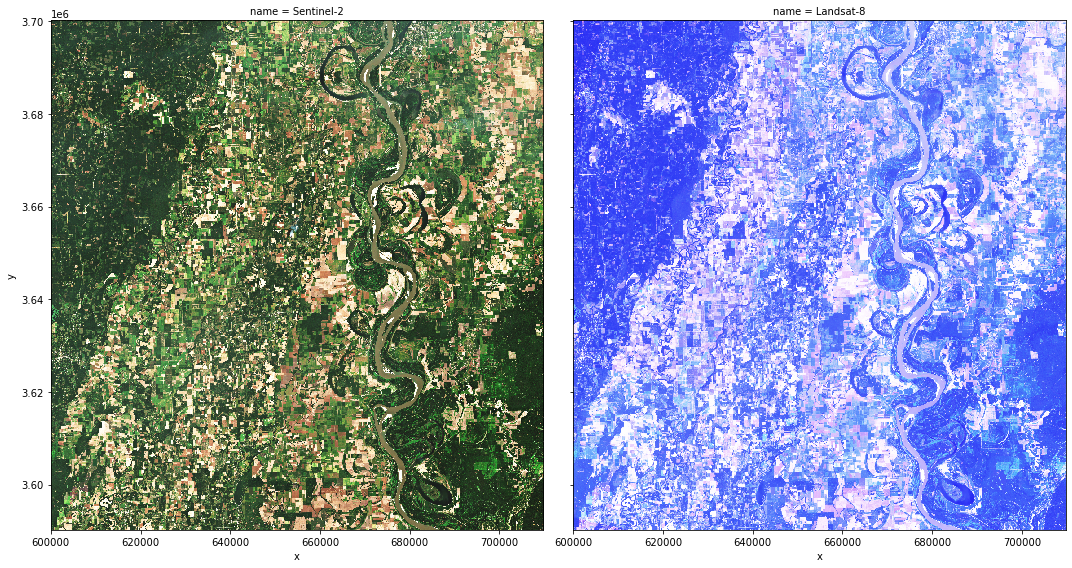

In [9]:
sentinel_image = ms.true_color(
    sentinel_data.sel(band="red"),
    sentinel_data.sel(band="green"),
    sentinel_data.sel(band="blue"),
    c=25,
    th=0.1,
    name="Sentinel-2",
)

landsat_image = ms.true_color(
    landsat_data.sel(band="red"),
    landsat_data.sel(band="green"),
    landsat_data.sel(band="blue"),
    c=25,
    th=0.1,
    name="Landsat-8",
)

org_imgs = xr.concat(
    [sentinel_image, landsat_image],
    pd.Index([sentinel_image.name, landsat_image.name], name="name"),
)

org_imgs.plot.imshow(x="x", y="y", col="name", figsize=(15, 8));

## Coregister Sentinel and Landsat data into one dataset

Combine Sentinel and Landsat data into a single [xarray Dataset](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.html).

In [10]:
coregistration_data = xr.Dataset(
    data_vars=dict(
        sentinel=(["band", "y", "x"], sentinel_data),
        landsat=(["band", "y", "x"], landsat_data),
    ),
    coords=dict(
        x=sentinel_data.x.data,
        y=sentinel_data.y.data,
        band=sentinel_data.band.data,
    ),
    attrs=sentinel_data.attrs,  # both dataset have the same attributes
)

coregistration_data

<xarray.Dataset>
Dimensions:   (band: 4, x: 1098, y: 1099)
Coordinates:
  * x         (x) float64 6e+05 6.001e+05 6.002e+05 ... 7.096e+05 7.097e+05
  * y         (y) float64 3.7e+06 3.7e+06 3.7e+06 ... 3.59e+06 3.59e+06
  * band      (band) <U5 'blue' 'green' 'red' 'nir'
Data variables:
    sentinel  (band, y, x) float64 nan nan nan ... 1.82e+03 3.51e+03 3.426e+03
    landsat   (band, y, x) float64 7.639e+03 7.62e+03 ... 1.906e+04 1.728e+04
Attributes:
    spec:        RasterSpec(epsg=32615, bounds=(600000, 3590200, 709800, 3700...
    crs:         epsg:32615
    transform:   | 100.00, 0.00, 600000.00|\n| 0.00,-100.00, 3700100.00|\n| 0...
    resolution:  100

## Wrap-up: compare NDVI

To compare the NDVIs of the individual datasets to the coregistered data, use [xrspatial.multispectral.ndvi](https://xarray-spatial.org/reference/_autosummary/xrspatial.multispectral.ndvi.html) with all three datasets.

First, compute the NVDIs for `sentinel_ndvi` and `landsat_ndvi`.

In [11]:
sentinel_ndvi = ms.ndvi(
    nir_agg=coregistration_data.sentinel.sel(band="nir"),
    red_agg=coregistration_data.sentinel.sel(band="red"),
    name="sentinel_ndvi",
)

landsat_ndvi = ms.ndvi(
    nir_agg=coregistration_data.landsat.sel(band="nir"),
    red_agg=coregistration_data.landsat.sel(band="red"),
    name="landsat_ndvi",
)

Next, compute the NDVI for the combined dataset. Use the nir band from Sentinel-2 and the red band from Landsat-8.

In [12]:
coregistration_ndvi = ms.ndvi(
    nir_agg=coregistration_data.sentinel.sel(band="nir"),
    red_agg=coregistration_data.landsat.sel(band="red"),
    name="coregistration_ndvi",
)

Finally, use xarray's [concat](http://xarray.pydata.org/en/stable/generated/xarray.concat.html) function to combine the three datasets into one array and display the results.

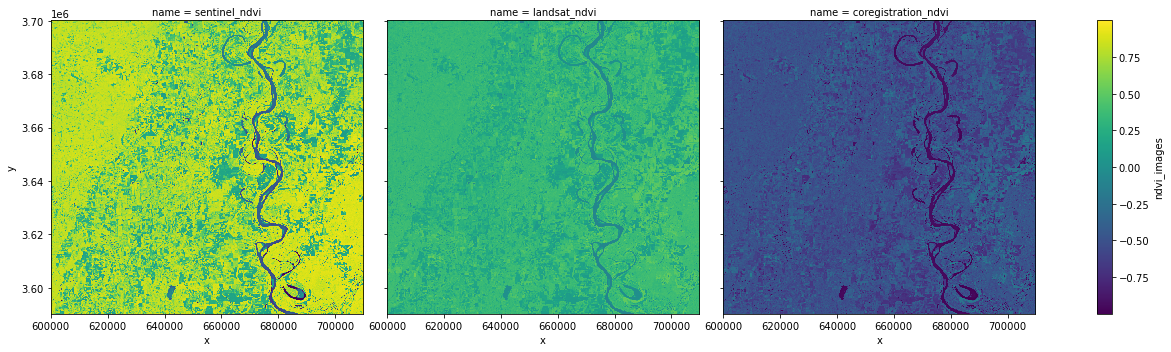

In [13]:
ndvi_imgs = xr.concat(
    [sentinel_ndvi, landsat_ndvi, coregistration_ndvi],
    pd.Index(
        [sentinel_ndvi.name, landsat_ndvi.name, coregistration_ndvi.name], name="name"
    ),
)

ndvi_imgs.name = "ndvi_images"

ndvi_imgs.plot.imshow(x="x", y="y", col="name", figsize=(18, 5), cmap="viridis");